# Basic Text Classification with Naive Bayes
***
In the mini-project, you'll learn the basics of text analysis using a subset of movie reviews from the rotten tomatoes database. You'll also use a fundamental technique in Bayesian inference, called Naive Bayes. This mini-project is based on [Lab 10 of Harvard's CS109](https://github.com/cs109/2015lab10) class.  Please free to go to the original lab for additional exercises and solutions.

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from six.moves import range

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

# Table of Contents

* [Rotten Tomatoes Dataset](#Rotten-Tomatoes-Dataset)
    * [Explore](#Explore)
* [The Vector Space Model and a Search Engine](#The-Vector-Space-Model-and-a-Search-Engine)
    * [In Code](#In-Code)
* [Naive Bayes](#Naive-Bayes)
    * [Multinomial Naive Bayes and Other Likelihood Functions](#Multinomial-Naive-Bayes-and-Other-Likelihood-Functions)
    * [Picking Hyperparameters for Naive Bayes and Text Maintenance](#Picking-Hyperparameters-for-Naive-Bayes-and-Text-Maintenance)
* [Interpretation](#Interpretation)


## Rotten Tomatoes Dataset

In [2]:
critics = pd.read_csv('/Users/luca/anaconda2/Springboard/data/critics.csv')
#let's drop rows with missing quotes
critics = critics[~critics.quote.isnull()]
critics.head()

,critic,fresh,imdb,publication,quote,review_date,rtid,title
1,Derek Adams,fresh,114709,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559,Toy story
2,Richard Corliss,fresh,114709,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559,Toy story
3,David Ansen,fresh,114709,Newsweek,A winning animated feature that has something ...,2008-08-18,9559,Toy story
4,Leonard Klady,fresh,114709,Variety,The film sports a provocative and appealing st...,2008-06-09,9559,Toy story
5,Jonathan Rosenbaum,fresh,114709,Chicago Reader,"An entertaining computer-generated, hyperreali...",2008-03-10,9559,Toy story


### Explore

In [3]:
n_reviews = len(critics)
n_movies = critics.rtid.unique().size
n_critics = critics.critic.unique().size


print("Number of reviews: {:d}".format(n_reviews))
print("Number of critics: {:d}".format(n_critics))
print("Number of movies:  {:d}".format(n_movies))

Number of reviews: 15561
Number of critics: 623
Number of movies:  1921


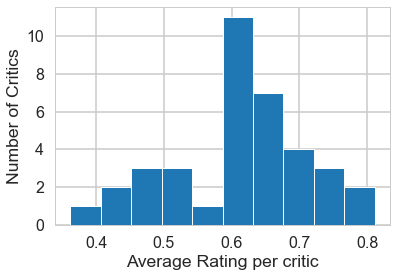

In [4]:
df = critics.copy()
df['fresh'] = df.fresh == 'fresh'
grp = df.groupby('critic')
counts = grp.critic.count()  # number of reviews by each critic
means = grp.fresh.mean()     # average freshness for each critic

means[counts > 100].hist(bins=10, edgecolor='w', lw=1)
plt.xlabel("Average Rating per critic")
plt.ylabel("Number of Critics")
plt.yticks([0, 2, 4, 6, 8, 10]);

<div class="span5 alert alert-info">
<h3>Exercise Set I</h3>
<br/>
<b>Exercise:</b> Look at the histogram above. Tell a story about the average ratings per critic. What shape does the distribution look like? What is interesting about the distribution? What might explain these interesting things?
</div>

Histogram shapes can be influenced by the bin number. Here for example, a bin of 5 instead of 10 looks much closer to normal through slightly heavy to the right side, but one of 100 looks much less like a normal distribution. Taking this histogram at face value, we see that it looks mostly normal as well through still heavy on the right side. We draw from it a few interesting suppositions about critics. Critics like to give positive ratings but not too positive. You can see that movies rated at .5 or below occur much less often. A large number occur between .6 and .7 and much fewer get above .7 marks. Critics are writers writing to a very broad audience. An audience who might not continue to read thier reviews if they don't agree with the critic more often than not. Hence, critics seem to sparingly give out either high or low ratings. Now critics might hide or subdue thier true rating or preference of a movie but does their crititic reflect that? 

## The Vector Space Model and a Search Engine

All the diagrams here are snipped from [*Introduction to Information Retrieval* by Manning et. al.]( http://nlp.stanford.edu/IR-book/) which is a great resource on text processing. For additional information on text mining and natural language processing, see [*Foundations of Statistical Natural Language Processing* by Manning and Schutze](http://nlp.stanford.edu/fsnlp/).

Also check out Python packages [`nltk`](http://www.nltk.org/), [`spaCy`](https://spacy.io/), [`pattern`](http://www.clips.ua.ac.be/pattern), and their associated resources. Also see [`word2vec`](https://en.wikipedia.org/wiki/Word2vec).

Let us define the vector derived from document $d$ by $\bar V(d)$. What does this mean? Each document is treated as a vector containing information about the words contained in it. Each vector has the same length and each entry "slot" in the vector contains some kind of data about the words that appear in the document such as presence/absence (1/0), count (an integer) or some other statistic. Each vector has the same length because each document shared the same vocabulary across the full collection of documents -- this collection is called a *corpus*.

To define the vocabulary, we take a union of all words we have seen in all documents. We then just associate an array index with them. So "hello" may be at index 5 and "world" at index 99.

Suppose we have the following corpus:

`A Fox one day spied a beautiful bunch of ripe grapes hanging from a vine trained along the branches of a tree. The grapes seemed ready to burst with juice, and the Fox's mouth watered as he gazed longingly at them.`

Suppose we treat each sentence as a document $d$. The vocabulary (often called the *lexicon*) is the following:

$V = \left\{\right.$ `a, along, and, as, at, beautiful, branches, bunch, burst, day, fox, fox's, from, gazed, grapes, hanging, he, juice, longingly, mouth, of, one, ready, ripe, seemed, spied, the, them, to, trained, tree, vine, watered, with`$\left.\right\}$

Then the document

`A Fox one day spied a beautiful bunch of ripe grapes hanging from a vine trained along the branches of a tree`

may be represented as the following sparse vector of word counts:

$$\bar V(d) = \left( 4,1,0,0,0,1,1,1,0,1,1,0,1,0,1,1,0,0,0,0,2,1,0,1,0,0,1,0,0,0,1,1,0,0 \right)$$

or more succinctly as

`[(0, 4), (1, 1), (5, 1), (6, 1), (7, 1), (9, 1), (10, 1), (12, 1), (14, 1), (15, 1), (20, 2), (21, 1), (23, 1),`
`(26, 1), (30, 1), (31, 1)]`

along with a dictionary

``
{
    0: a, 1: along, 5: beautiful, 6: branches, 7: bunch, 9: day, 10: fox, 12: from, 14: grapes, 
    15: hanging, 19: mouth, 20: of, 21: one, 23: ripe, 24: seemed, 25: spied, 26: the, 
    30: tree, 31: vine, 
}
``

Then, a set of documents becomes, in the usual `sklearn` style, a sparse matrix with rows being sparse arrays representing documents and columns representing the features/words in the vocabulary.

Notice that this representation loses the relative ordering of the terms in the document. That is "cat ate rat" and "rat ate cat" are the same. Thus, this representation is also known as the Bag-Of-Words representation.

Here is another example, from the book quoted above, although the matrix is transposed here so that documents are columns:

![novel terms](terms.png)

Such a matrix is also catted a Term-Document Matrix. Here, the terms being indexed could be stemmed before indexing; for instance, `jealous` and `jealousy` after stemming are the same feature. One could also make use of other "Natural Language Processing" transformations in constructing the vocabulary. We could use Lemmatization, which reduces words to lemmas: work, working, worked would all reduce to work. We could remove "stopwords" from our vocabulary, such as common words like "the". We could look for particular parts of speech, such as adjectives. This is often done in Sentiment Analysis. And so on. It all depends on our application.

From the book:
>The standard way of quantifying the similarity between two documents $d_1$ and $d_2$  is to compute the cosine similarity of their vector representations $\bar V(d_1)$ and $\bar V(d_2)$:

$$S_{12} = \frac{\bar V(d_1) \cdot \bar V(d_2)}{|\bar V(d_1)| \times |\bar V(d_2)|}$$

![Vector Space Model](vsm.png)


>There is a far more compelling reason to represent documents as vectors: we can also view a query as a vector. Consider the query q = jealous gossip. This query turns into the unit vector $\bar V(q)$ = (0, 0.707, 0.707) on the three coordinates below. 

![novel terms](terms2.png)

>The key idea now: to assign to each document d a score equal to the dot product:

$$\bar V(q) \cdot \bar V(d)$$

Then we can use this simple Vector Model as a Search engine.

### In Code

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

text = ['Hop on pop', 'Hop off pop', 'Hop Hop hop']
print("Original text is\n{}".format('\n'.join(text)))

vectorizer = CountVectorizer(min_df=0)

# call `fit` to build the vocabulary
vectorizer.fit(text)

# call `transform` to convert text to a bag of words
x = vectorizer.transform(text)

# CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
# convert back to a "normal" numpy array
x = x.toarray()

print("")
print("Transformed text vector is \n{}".format(x))

# `get_feature_names` tracks which word is associated with each column of the transformed x
print("")
print("Words for each feature:")
print(vectorizer.get_feature_names())

# Notice that the bag of words treatment doesn't preserve information about the *order* of words, 
# just their frequency

Original text is
Hop on pop
Hop off pop
Hop Hop hop

Transformed text vector is 
[[1 0 1 1]
 [1 1 0 1]
 [3 0 0 0]]

Words for each feature:
[u'hop', u'off', u'on', u'pop']


In [6]:
def make_xy(critics, vectorizer=None):
    #Your code here    
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(critics.quote)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = (critics.fresh == 'fresh').values.astype(np.int)
    return X, y
X, y = make_xy(critics)

## Naive Bayes

From Bayes' Theorem, we have that

$$P(c \vert f) = \frac{P(c \cap f)}{P(f)}$$

where $c$ represents a *class* or category, and $f$ represents a feature vector, such as $\bar V(d)$ as above. **We are computing the probability that a document (or whatever we are classifying) belongs to category *c* given the features in the document.** $P(f)$ is really just a normalization constant, so the literature usually writes Bayes' Theorem in context of Naive Bayes as

$$P(c \vert f) \propto P(f \vert c) P(c) $$

$P(c)$ is called the *prior* and is simply the probability of seeing class $c$. But what is $P(f \vert c)$? This is the probability that we see feature set $f$ given that this document is actually in class $c$. This is called the *likelihood* and comes from the data. One of the major assumptions of the Naive Bayes model is that the features are *conditionally independent* given the class. While the presence of a particular discriminative word may uniquely identify the document as being part of class $c$ and thus violate general feature independence, conditional independence means that the presence of that term is independent of all the other words that appear *within that class*. This is a very important distinction. Recall that if two events are independent, then:

$$P(A \cap B) = P(A) \cdot P(B)$$

Thus, conditional independence implies

$$P(f \vert c)  = \prod_i P(f_i | c) $$

where $f_i$ is an individual feature (a word in this example).

To make a classification, we then choose the class $c$ such that $P(c \vert f)$ is maximal.

There is a small caveat when computing these probabilities. For [floating point underflow](http://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html) we change the product into a sum by going into log space. This is called the LogSumExp trick. So:

$$\log P(f \vert c)  = \sum_i \log P(f_i \vert c) $$

There is another caveat. What if we see a term that didn't exist in the training data? This means that $P(f_i \vert c) = 0$ for that term, and thus $P(f \vert c)  = \prod_i P(f_i | c) = 0$, which doesn't help us at all. Instead of using zeros, we add a small negligible value called $\alpha$ to each count. This is called Laplace Smoothing.

$$P(f_i \vert c) = \frac{N_{ic}+\alpha}{N_c + \alpha N_i}$$

where $N_{ic}$ is the number of times feature $i$ was seen in class $c$, $N_c$ is the number of times class $c$ was seen and $N_i$ is the number of times feature $i$ was seen globally. $\alpha$ is sometimes called a regularization parameter.

### Multinomial Naive Bayes and Other Likelihood Functions

Since we are modeling word counts, we are using variation of Naive Bayes called Multinomial Naive Bayes. This is because the likelihood function actually takes the form of the multinomial distribution.

$$P(f \vert c) = \frac{\left( \sum_i f_i \right)!}{\prod_i f_i!} \prod_{f_i} P(f_i \vert c)^{f_i} \propto \prod_{i} P(f_i \vert c)$$

where the nasty term out front is absorbed as a normalization constant such that probabilities sum to 1.

There are many other variations of Naive Bayes, all which depend on what type of value $f_i$ takes. If $f_i$ is continuous, we may be able to use *Gaussian Naive Bayes*. First compute the mean and variance for each class $c$. Then the likelihood, $P(f \vert c)$ is given as follows

$$P(f_i = v \vert c) = \frac{1}{\sqrt{2\pi \sigma^2_c}} e^{- \frac{\left( v - \mu_c \right)^2}{2 \sigma^2_c}}$$

<div class="span5 alert alert-info">
<h3>Exercise Set II</h3>

<p><b>Exercise:</b> Implement a simple Naive Bayes classifier:</p>

<ol>
<li> split the data set into a training and test set
<li> Use `scikit-learn`'s `MultinomialNB()` classifier with default parameters.
<li> train the classifier over the training set and test on the test set
<li> print the accuracy scores for both the training and the test sets
</ol>

What do you notice? Is this a good classifier? If not, why not?
</div>

In [7]:
#your turn

#import machine learning modules
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score


#transform data into vectors
x,y=make_xy(critics)

# split into training and test sets
x_train, x_test, y_train, y_test= train_test_split(x,y, test_size=.3, random_state=42)

#initiate the naive bayes classifier
clf = MultinomialNB()

# Fit the model on the trainng data.
clf.fit( x_train,y_train)

#print the accuracy on the training data
training_accuracy = clf.score(x_train, y_train)
print("Accuracy on training data: {:0.2f}".format(training_accuracy))

#print the accuracy on the test data
test_accuracy = clf.score(x_test, y_test)
print("Accuracy on test data:     {:0.2f}".format(test_accuracy))


Accuracy on training data: 0.92
Accuracy on test data:     0.78


The fit on the training data is high compared to the test dats, therefore, I would suspect that the model is overfitting. However, the prediction on the test set is not bad. We do predict 78% correctly.

### Picking Hyperparameters for Naive Bayes and Text Maintenance

We need to know what value to use for $\alpha$, and we also need to know which words to include in the vocabulary. As mentioned earlier, some words are obvious stopwords. Other words appear so infrequently that they serve as noise, and other words in addition to stopwords appear so frequently that they may also serve as noise.

First, let's find an appropriate value for `min_df` for the `CountVectorizer`. `min_df` can be either an integer or a float/decimal. If it is an integer, `min_df` represents the minimum number of documents a word must appear in for it to be included in the vocabulary. If it is a float, it represents the minimum *percentage* of documents a word must appear in to be included in the vocabulary. From the documentation:

>min_df: When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.

<div class="span5 alert alert-info">
<h3>Exercise Set III</h3>

<p><b>Exercise:</b> Construct the cumulative distribution of document frequencies (df). The $x$-axis is a document count $x_i$ and the $y$-axis is the percentage of words that appear less than $x_i$ times. For example, at $x=5$, plot a point representing the percentage or number of words that appear in 5 or fewer documents.</p>

<p><b>Exercise:</b> Look for the point at which the curve begins climbing steeply. This may be a good value for `min_df`. If we were interested in also picking `max_df`, we would likely pick the value where the curve starts to plateau. What value did you choose?</p>
</div>

In [8]:
vectorizer.fit(critics.quote)
df=vectorizer.fit_transform(critics.quote)

In [9]:
df_vectors=df.toarray()

In [10]:
word_freq=df.toarray().sum(axis=0)
word_freq

array([ 8,  1, 10, ...,  3,  1,  1])

In [11]:
word_freq.sum()

295413

In [12]:
from collections import Counter
word_doc=Counter(word_freq)
word_doc

Counter({1: 9552,
         2: 3486,
         3: 1916,
         4: 1259,
         5: 896,
         6: 634,
         7: 532,
         8: 415,
         9: 354,
         10: 294,
         11: 235,
         12: 212,
         13: 185,
         14: 176,
         15: 135,
         16: 104,
         17: 106,
         18: 90,
         19: 95,
         20: 77,
         21: 83,
         22: 75,
         23: 57,
         24: 48,
         25: 53,
         26: 53,
         27: 42,
         28: 48,
         29: 44,
         30: 45,
         31: 35,
         32: 28,
         33: 34,
         34: 36,
         35: 26,
         36: 27,
         37: 21,
         38: 18,
         39: 25,
         40: 19,
         41: 20,
         42: 23,
         43: 18,
         44: 21,
         45: 17,
         46: 17,
         47: 20,
         48: 10,
         49: 17,
         50: 12,
         51: 7,
         52: 13,
         53: 20,
         54: 6,
         55: 10,
         56: 17,
         57: 14,
         58: 10,
    

In [13]:
sum(word_doc.values())

22417

In [14]:
words = list(vectorizer.get_feature_names())
word_count = Counter(dict(zip(words, word_freq)))
print (word_count.most_common(50))

[(u'the', 16805), (u'and', 9904), (u'of', 9778), (u'to', 6238), (u'is', 5974), (u'it', 5332), (u'in', 4252), (u'that', 3681), (u'as', 2858), (u'with', 2577), (u'but', 2411), (u'this', 2335), (u'film', 2267), (u'movie', 2199), (u'for', 2148), (u'its', 1903), (u'an', 1836), (u'be', 1408), (u'you', 1408), (u'on', 1390), (u'by', 1331), (u'has', 1301), (u'one', 1295), (u'not', 1237), (u'are', 1157), (u'more', 1121), (u'his', 1085), (u'all', 1069), (u'than', 1037), (u'at', 1024), (u'about', 1018), (u'from', 993), (u'have', 887), (u'so', 875), (u'like', 864), (u'most', 821), (u'there', 790), (u'what', 744), (u'if', 711), (u'he', 703), (u'or', 702), (u'good', 691), (u'can', 689), (u'who', 688), (u'up', 663), (u'story', 657), (u'into', 644), (u'much', 615), (u'out', 599), (u'comedy', 591)]


In [15]:
sum(word_count.values())

295413

In [16]:

#create dict to count word occurance in document(sentences)
dict_words={i:0 for i in range(len(df_vectors[0]))}
vocab = list(vectorizer.get_feature_names())

In [17]:
# loop over words in sentences
for i in xrange(len(df_vectors[0])):
    
    #value holder for word occurances in sentences
    y=0
    
    #loop over document/sentences counting word occurances
    #sum up sentence/document one first word occurance with sentence/document two word one...
    for j in xrange(len (df_vectors)):
        y=y+df_vectors[j][i]
        
    #save word occurs in documents to dictionary
    dict_words[i]=y
    
    #loop increments to next word to sum over sentences\

In [18]:
#use counter to sum word occurance 
word_pert=Counter(dict_words.values())

In [19]:
#should be same as word_doc
word_pert

Counter({1: 9552,
         2: 3486,
         3: 1916,
         4: 1259,
         5: 896,
         6: 634,
         7: 532,
         8: 415,
         9: 354,
         10: 294,
         11: 235,
         12: 212,
         13: 185,
         14: 176,
         15: 135,
         16: 104,
         17: 106,
         18: 90,
         19: 95,
         20: 77,
         21: 83,
         22: 75,
         23: 57,
         24: 48,
         25: 53,
         26: 53,
         27: 42,
         28: 48,
         29: 44,
         30: 45,
         31: 35,
         32: 28,
         33: 34,
         34: 36,
         35: 26,
         36: 27,
         37: 21,
         38: 18,
         39: 25,
         40: 19,
         41: 20,
         42: 23,
         43: 18,
         44: 21,
         45: 17,
         46: 17,
         47: 20,
         48: 10,
         49: 17,
         50: 12,
         51: 7,
         52: 13,
         53: 20,
         54: 6,
         55: 10,
         56: 17,
         57: 14,
         58: 10,
    

In [20]:
#now we want freq of words that appear in i documents (for x=5 that is words that appear in 5 documents)
#empty variable for counting
x=0

#list of words per document for plotting later
x_points=[]

#list to hold word document counts and initialize with a zero for plotting later
p_pert=[]

#loop over 
for i in word_doc.values():
    x+=i
    p=x
    x_points.append(x)
    p_pert.append(p)
    

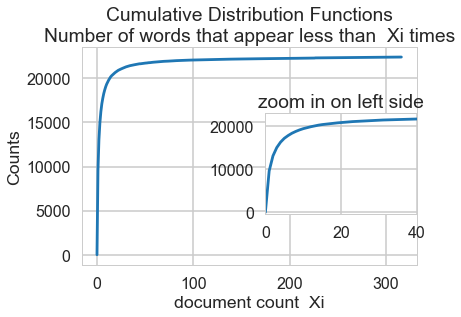

In [21]:
n = len(p_pert)
fig, ax =plt.subplots()
x=np.linspace(0,316,num=n)
ax.plot(x,p_pert)
#_ = plt.xlim(0,316)
_ = ax.set_xlabel('document count  Xi')
_ = ax.set_ylabel('Counts')
_ = ax.set_title('Cumulative Distribution Functions\nNumber of words that appear less than  Xi times')


inset_ax=fig.add_axes([0.55,.3,.35,.35])
inset_ax.plot(x,p_pert)
inset_ax.set_title('zoom in on left side')
inset_ax.set_frame_on('on')

inset_ax.set_xlim(0,40)
plt.margins(0.02)

plt.show()

## Exercise: Look for the point at which the curve begins climbing steeply. This may be a good value for min_df. If we were interested in also picking max_df, we would likely pick the value where the curve starts to plateau. What value did you choose?


Here we are looking at counts of words that appear in a document. X=1 then is all words that appear in exactly one document. In our data, words that appear in one document number 9552. We see that the data stabilizes after 10 documents for which words appear in. I, therefore, would recommend picking 10 as the min_df. 


The parameter $\alpha$ is chosen to be a small value that simply avoids having zeros in the probability computations. This value can sometimes be chosen arbitrarily with domain expertise, but we will use K-fold cross validation. In K-fold cross-validation, we divide the data into $K$ non-overlapping parts. We train on $K-1$ of the folds and test on the remaining fold. We then iterate, so that each fold serves as the test fold exactly once. The function `cv_score` performs the K-fold cross-validation algorithm for us, but we need to pass a function that measures the performance of the algorithm on each fold. 

In [22]:
from sklearn.model_selection import KFold
def cv_score(clf, X, y, scorefunc):
    result = 0.
    nfold = 5
    for train, test in KFold(nfold).split(X): # split data into train/test groups, 5 times
        clf.fit(X[train], y[train]) # fit the classifier, passed is as clf.
        result += scorefunc(clf, X[test], y[test]) # evaluate score function on held-out data
    return result / nfold # average

We use the log-likelihood as the score here in `scorefunc`. The higher the log-likelihood, the better. Indeed, what we do in `cv_score` above is to implement the cross-validation part of `GridSearchCV`.

The custom scoring function `scorefunc` allows us to use different metrics depending on the decision risk we care about (precision, accuracy, profit etc.) directly on the validation set. You will often find people using `roc_auc`, precision, recall, or `F1-score` as the scoring function.

In [23]:
def log_likelihood(clf, x, y):
    prob = clf.predict_log_proba(x)
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

We'll cross-validate over the regularization parameter $\alpha$.

Let's set up the train and test masks first, and then we can run the cross-validation procedure.

In [24]:
from sklearn.model_selection import train_test_split
_, itest = train_test_split(range(critics.shape[0]), train_size=0.7)
mask = np.zeros(critics.shape[0], dtype=np.bool)
mask[itest] = True

/Users/luca/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


<div class="span5 alert alert-info">
<h3>Exercise Set IV</h3>

<p><b>Exercise:</b> What does using the function `log_likelihood` as the score mean? What are we trying to optimize for?</p>

<p><b>Exercise:</b> Without writing any code, what do you think would happen if you choose a value of $\alpha$ that is too high?</p>

<p><b>Exercise:</b> Using the skeleton code below, find the best values of the parameter `alpha`, and use the value of `min_df` you chose in the previous exercise set. Use the `cv_score` function above with the `log_likelihood` function for scoring.</p>
</div>

We are trying to optimize for the parameter selection. We want the maximum likelihood of data with respect to our parameters. A maximum likelihood selects the parameter so that the data is most likely to occur. Using the log_likelihood allows us to use the sum instead of the product. Two benefits of this is, it of keeping us from running out of floating point precision since the product gets very small quickly, and the computation is easier. 

If you choose an alpha that is to high, then your estimation/prediction is giving excess weight to items that did not occur in your data. You are in essense saying that what was not seen is much more likely to occur than what was seen. Your predictions will be much worse in the end. (Alpha is the smoothing term here)




In [25]:
from sklearn.naive_bayes import MultinomialNB

#the grid of parameters to search over
alphas = [.1, 1, 5, 10, 50]
best_min_df = 20 # YOUR TURN: put your value of min_df here.

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
maxscore=-np.inf
for alpha in alphas:        
    vectorizer = CountVectorizer(min_df=best_min_df)       
    Xthis, ythis = make_xy(critics, vectorizer)
    Xtrainthis = Xthis[mask]
    ytrainthis = ythis[mask]
    # your turn
    #initiate the naive bayes classifier
    clf = MultinomialNB(alpha=alpha)
    #call the score function to fit and evaluate
    cross_score =  cv_score(clf,Xtrainthis,ytrainthis,log_likelihood)
    
    #save best score for comparsion in next loop
    if cross_score>maxscore:
        maxscore=cross_score
        best_alpha=alpha
#print best of the results        
print("The best score of {}".format(maxscore))

The best score of -562.168726231


In [26]:
print("alpha: {}".format(best_alpha))

alpha: 5


<div class="span5 alert alert-info">
<h3>Exercise Set V: Working with the Best Parameters</h3>

<p><b>Exercise:</b> Using the best value of  `alpha` you just found, calculate the accuracy on the training and test sets. Is this classifier better? Why (not)?</p>

</div>

In [27]:
n_vectorizer = CountVectorizer(min_df=best_min_df)
X, y = make_xy(critics, n_vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.786250
Accuracy on test data:     0.712817


In [28]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(ytest, clf.predict(xtest)))

[[1979 2333]
 [ 795 5785]]


Yes, this is a better classifier. Previously, we got accuracy on training data at .92 and test data at .72. Here, we got accuracy on training data a .79 and test data at .71. This is better since we are not overfitting. Overfitting is the use of noise in the data to model the prediction. You can see this by the difference in test accuracy compared to training accuracy. The first case had a difference of .2 compared with .07 this time. The second model is using much less noise to make predictions thus its predictions can be considered to be more reliable even through the score is the same.

## Interpretation

### What are the strongly predictive features?

We use a neat trick to identify strongly predictive features (i.e. words). 

* first, create a data set such that each row has exactly one feature. This is represented by the identity matrix.
* use the trained classifier to make predictions on this matrix
* sort the rows by predicted probabilities, and pick the top and bottom $K$ rows

In [29]:
words = np.array(vectorizer.get_feature_names())

x = np.eye(xtest.shape[1])
probs = clf.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Good words\t     P(fresh | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("Bad words\t     P(fresh | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

Good words	     P(fresh | word)
('        entertaining', '0.88')
('               smart', '0.88')
('            touching', '0.86')
('         intelligent', '0.86')
('         masterpiece', '0.85')
('              modern', '0.85')
('         performance', '0.84')
('          remarkable', '0.84')
('               years', '0.84')
('             perfect', '0.83')
Bad words	     P(fresh | word)
('              stupid', '0.29')
('           pointless', '0.29')
('              sitcom', '0.29')
('              unless', '0.28')
('      disappointment', '0.28')
('                lame', '0.28')
('               sadly', '0.26')
('                dull', '0.24')
('               bland', '0.21')
('       unfortunately', '0.19')


<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Why does this method work? What does the probability for each row in the identity matrix represent</p>

</div>

The probability of each row is the probility that the feature/word will be in the catagory fresh (recieve a good rating by the critic). This probability also tells us which features/words our classifer is using to determine if a critics review will be 'fresh'. It works because the Naive Bayes' pred_proba returns the probability for each word/feature set given the class/document, P(f|c), i.e. the likelihood.

The above exercise is an example of *feature selection*. There are many other feature selection methods. A list of feature selection methods available in `sklearn` is [here](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection). The most common feature selection technique for text mining is the chi-squared $\left( \chi^2 \right)$ [method](http://nlp.stanford.edu/IR-book/html/htmledition/feature-selectionchi2-feature-selection-1.html).

### Prediction Errors

We can see mis-predictions as well.

In [30]:
x, y = make_xy(critics, vectorizer)

prob = clf.predict_proba(x)[:, 0]
predict = clf.predict(x)

bad_rotten = np.argsort(prob[y == 0])[:5]
bad_fresh = np.argsort(prob[y == 1])[-5:]

print("Mis-predicted Rotten quotes")
print('---------------------------')
for row in bad_rotten:
    print(critics[y == 0].quote.iloc[row])
    print("")

print("Mis-predicted Fresh quotes")
print('--------------------------')
for row in bad_fresh:
    print(critics[y == 1].quote.iloc[row])
    print("")

Mis-predicted Rotten quotes
---------------------------
Walken is one of the few undeniably charismatic male villains of recent years; he can generate a snakelike charm that makes his worst characters the most memorable, and here he operates on pure style.

It is sometimes funny in a puzzling kind of way, it is generally overwrought in an irritating kind of way, and once in a while it is inappropriately touching.

The hip, smart yarn has a bite not seen in American movies since The War of the Roses.

Part comedy, part family drama, part romance, part special-effects mystery-adventure, and not entirely satisfying on any of these levels.

Lauded as a witty moral fable with a revelatory performance from its star, this romantic comedy is in fact meretricious, manipulative and reactionary.

Mis-predicted Fresh quotes
--------------------------
It's often impossible to distinguish what's meant to be cartoonish from what's meant to be dramatic, but the confusion seems appropriately adolescent

<div class="span5 alert alert-info">
<h3>Exercise Set VII: Predicting the Freshness for a New Review</h3>
<br/>
<div>
<b>Exercise:</b>
<ul>
<li> Using your best trained classifier, predict the freshness of the following sentence: *'This movie is not remarkable, touching, or superb in any way'*
<li> Is the result what you'd expect? Why (not)?
</ul>
</div>
</div>

In [31]:
new_text=['This movie is not remarkable, touching, or superb in any way']
type(new_text)

list

In [32]:
#change text into vector
new_text=vectorizer.transform(new_text)


In [33]:
#make prediciton on new set
print(clf.predict(new_text))


[1]


It predicts that this sentence would be classified as 'fresh'. This would be a false positive as we can tell from reading the sentence. It is not too surprising that the classifier gets this wrong. The classifier here is only looking at words that have a high probability of being in the class 'fresh'. This sentence contains at three words we would expect to be highly associated with the 'fresh' class, hence, it predicts it is. The 'not' here does not alert the classifer that these three positive words should be negatively associated resulting in a misclassification. 

### Aside: TF-IDF Weighting for Term Importance

TF-IDF stands for 

`Term-Frequency X Inverse Document Frequency`.

In the standard `CountVectorizer` model above, we used just the term frequency in a document of words in our vocabulary. In TF-IDF, we weight this term frequency by the inverse of its popularity in all documents. For example, if the word "movie" showed up in all the documents, it would not have much predictive value. It could actually be considered a stopword. By weighing its counts by 1 divided by its overall frequency, we downweight it. We can then use this TF-IDF weighted features as inputs to any classifier. **TF-IDF is essentially a measure of term importance, and of how discriminative a word is in a corpus.** There are a variety of nuances involved in computing TF-IDF, mainly involving where to add the smoothing term to avoid division by 0, or log of 0 errors. The formula for TF-IDF in `scikit-learn` differs from that of most textbooks: 

$$\mbox{TF-IDF}(t, d) = \mbox{TF}(t, d)\times \mbox{IDF}(t) = n_{td} \log{\left( \frac{\vert D \vert}{\vert d : t \in d \vert} + 1 \right)}$$

where $n_{td}$ is the number of times term $t$ occurs in document $d$, $\vert D \vert$ is the number of documents, and $\vert d : t \in d \vert$ is the number of documents that contain $t$

In [34]:
# http://scikit-learn.org/dev/modules/feature_extraction.html#text-feature-extraction
# http://scikit-learn.org/dev/modules/classes.html#text-feature-extraction-ref
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfvectorizer = TfidfVectorizer(min_df=1, stop_words='english')
Xtfidf=tfidfvectorizer.fit_transform(critics.quote)

<div class="span5 alert alert-info">
<h3>Exercise Set VIII: Enrichment</h3>

<p>
There are several additional things we could try. Try some of these as exercises:
<ol>
<li> Build a Naive Bayes model where the features are n-grams instead of words. N-grams are phrases containing n words next to each other: a bigram contains 2 words, a trigram contains 3 words, and 6-gram contains 6 words. This is useful because "not good" and "so good" mean very different things. On the other hand, as n increases, the model does not scale well since the feature set becomes more sparse.
<li> Try a model besides Naive Bayes, one that would allow for interactions between words -- for example, a Random Forest classifier.
<li> Try adding supplemental features -- information about genre, director, cast, etc.
<li> Use word2vec or [Latent Dirichlet Allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) to group words into topics and use those topics for prediction.
<li> Use TF-IDF weighting instead of word counts.
</ol>
</p>

<b>Exercise:</b> Try a few of these ideas to improve the model (or any other ideas of your own). Implement here and report on the result.
</div>

In [35]:
vec = CountVectorizer(analyzer ='word',min_df=10, ngram_range=(2, 2))

vec.fit(critics.quote)
ng=vec.fit_transform(critics.quote)
ng_vectors=ng.toarray()
ng_word_freq=ng.toarray().sum(axis=0)
print(ng_word_freq)
ng_word_doc=Counter(ng_word_freq)
ng_word_doc

[11 28 31 ..., 21 11 12]


Counter({10: 319,
         11: 246,
         12: 185,
         13: 168,
         14: 152,
         15: 108,
         16: 111,
         17: 103,
         18: 81,
         19: 67,
         20: 50,
         21: 70,
         22: 54,
         23: 39,
         24: 44,
         25: 32,
         26: 32,
         27: 30,
         28: 34,
         29: 21,
         30: 21,
         31: 24,
         32: 23,
         33: 29,
         34: 20,
         35: 12,
         36: 16,
         37: 15,
         38: 14,
         39: 13,
         40: 14,
         41: 14,
         42: 8,
         43: 16,
         44: 4,
         45: 9,
         46: 8,
         47: 9,
         48: 7,
         49: 5,
         50: 7,
         51: 13,
         52: 5,
         53: 6,
         54: 12,
         55: 5,
         56: 8,
         57: 4,
         58: 4,
         59: 4,
         60: 6,
         61: 2,
         62: 5,
         63: 6,
         64: 7,
         65: 2,
         66: 2,
         67: 2,
         68: 2,
         70: 

In [ ]:
ng_words = list(vec.get_feature_names())
ng_word_count = Counter(dict(zip(ng_words, ng_word_freq)))
print (ng_word_count.most_common(50))

In [38]:

#print best of the results        
print("Using the min_df: {} and the alpha: {} from before with 2 n-grams we get:".format(best_min_df,best_alpha))


# Your turn best_min_df best_alpha
vec = CountVectorizer(min_df=best_min_df, ngram_range=(2, 2))

x_ng, y_ng = make_xy(critics, vec)

xtrainng=x_ng[mask]
ytrainng=y_ng[mask]
xtestng=x_ng[~mask]
ytestng=y_ng[~mask]

ngclf = MultinomialNB(alpha= best_alpha).fit(xtrainng, ytrainng)

#Print the accuracy on the test and training dataset
ngtraining_accuracy = ngclf.score(xtrainng, ytrainng)
ngtest_accuracy = ngclf.score(xtestng, ytestng)

print("Accuracy on training data: {:2f}".format(ngtraining_accuracy))
print("Accuracy on test data:     {:2f}".format(ngtest_accuracy))

Using the min_df: 20 and the alpha: 5 from before with 2 n-grams we get:
Accuracy on training data: 0.708289
Accuracy on test data:     0.639001


It looks like with 2 n-grams we lower the noise in the model but predict worse overall. How should we that this? We miss more predictions but on the correct answers we can be more confident that are model is correct. Lets look at an example. 

In [39]:
#test review to predict
new_text=['This movie is not bad']

#2-gram prediction
new_vec=vec.transform(new_text)
print(ngclf.predict(new_vec),'fresh: 2-gram')
print(ngclf.predict_proba(new_vec))

#only singel word prediction
new_vec=vectorizer.transform(new_text)
print(clf.predict(new_vec),'fresh: word only')
print(clf.predict_proba(new_vec))

(array([1]), 'fresh: 2-gram')
[[ 0.43544347  0.56455653]]
(array([0]), 'fresh: word only')
[[ 0.55399577  0.44600423]]


The model, while not predicting better overall, does do a better job handling the flip pharses when calculating probability. We see that it does at least catch this flip pharse correctly where the original model did not. This is why we wanted to look a the 2 n-gram model. 

In [40]:
#print parameters of the results        
print("Using the min_df: {} and the alpha: {} from before with TF-IDF we get:".format(best_min_df,best_alpha))

tfidfvectorizer = TfidfVectorizer(min_df=best_min_df, stop_words='english')

x_tfid, y_tfid = make_xy(critics, tfidfvectorizer)
xtraintfid=x_tfid[mask]
ytraintfid=y_tfid[mask]
xtesttfid=x_tfid[~mask]
ytesttfid=y_tfid[~mask]

tfid_clf = MultinomialNB(alpha=best_alpha).fit(xtraintfid, ytraintfid)

#Print the accuracy on the test and training dataset
training_accuracy = tfid_clf.score(xtraintfid, ytraintfid)
test_accuracy = tfid_clf.score(xtesttfid, ytesttfid)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))


Using the min_df: 20 and the alpha: 5 from before with TF-IDF we get:
Accuracy on training data: 0.700150
Accuracy on test data:     0.645887


In [175]:
def accy_score(clf, x, y):
    prob = clf.score(x,y)
    rotten = y == 0
    fresh = ~rotten
    return prob


In [176]:
accy_score(rf, xtrainrf, ytrainrf)

0.99614478475048185

In [179]:
#print best of the results        
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
x,y=make_xy(critics)

# split into training and test sets
x_train, x_test, y_train, y_test= train_test_split(x,y, test_size=.3, random_state=42)

rf = RandomForestClassifier()

# Fit the model on the trainng data.
rf.fit( x_train,y_train)

#print the accuracy on the training data
training_accuracy = rf.score(x_train, y_train)
print("Accuracy on training data: {:0.2f}".format(training_accuracy))

ftest_accuracy = rf.score(x_test, y_test)
print("Accuracy on test data: {:0.2f}".format(ftest_accuracy))


# Your turn best_min_df best_alpha
vec = CountVectorizer(min_df=best_min_df)

x_rf, y_rf = make_xy(critics, vec)

xtrainrf=x_rf[mask]
ytrainrf=y_rf[mask]
xtestrf=x_rf[~mask]
ytestrf=y_rf[~mask]

rf=RandomForestClassifier()
best_tree=0
#impurity_decrease=[0,.1,.2,.5,.7,1](min_impurity_decrease=i
trees=[1,10,100,1000]
features=[10,100,1000,'sqrt']
best_feature=0
best_score=0
for i in tqdm(trees):
    for j in tqdm(features):
        rf=RandomForestClassifier(max_features= j, n_estimators=i)
        rf.fit(xtrain,ytrainrf)
        
        score=accy_score(rf, xtrainrf, ytrainrf)
        if score>best_score:
            best_score=score
            best_tree=i
            best_feature=j
rf = RandomForestClassifier(max_features= best_feature,n_estimators=best_tree).fit(xtrainrf, ytrainrf)

#Print the accuracy on the test and training dataset
rftraining_accuracy = rf.score(xtrainrf, ytrainrf)
rftest_accuracy = rf.score(xtestrf, ytestrf)
print(best_feature,best_tree,best_score)
print("Accuracy on training data with {}: {:2f}".format(best_estimators,rftraining_accuracy))
print("Accuracy on test data with {}:     {:2f}".format(best_estimators,rftest_accuracy))


Accuracy on training data: 0.99
Accuracy on test data: 0.68


100%|██████████| 4/4 [03:48<00:00, 57.19s/it]


(10, 100, 0.99614478475048185)
Accuracy on training data with 0: 0.996145
Accuracy on test data with 0:     0.687018


Here we see that the model does even better the 2 n-gram with prediction and noise reduction. However, worse than the original model. 

In [43]:
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize
model= NMF(n_components=6)
model.fit(x_tfid)
nfm_features=model.transform(x_tfid)
norm=normalize(nfm_features)
dfn=pd.DataFrame(norm)



 

norm.dot(X)

In [44]:
dfn

,0,1,2,3,4,5
0,0.073215,0.036170,0.984958,0.000000,0.102567,0.112555
1,0.005654,0.000000,0.021850,0.014467,0.000000,0.999641
2,0.000000,0.092953,0.880810,0.003863,0.061723,0.460117
3,0.000000,0.938685,0.344777,0.000651,0.000000,0.000000
4,0.013830,0.017659,0.996790,0.062738,0.000000,0.044396
5,0.507318,0.000000,0.859614,0.060765,0.000000,0.000000
6,0.000000,0.916930,0.397324,0.036676,0.000000,0.005326
7,0.039935,0.114932,0.981916,0.068491,0.040790,0.121167
8,0.032244,0.037400,0.994840,0.000000,0.000000,0.088631
9,0.005677,0.004269,0.076522,0.996680,0.025193,0.009355


In [113]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf= TfidfVectorizer()
csr_mat = tfidf.fit_transform(critics.quote)
words =tfidf.get_feature_names()
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
svd =TruncatedSVD(n_components=50)
kmeans=KMeans(n_clusters=2)
pipeline=make_pipeline(svd,kmeans)


In [114]:
pipeline.fit(csr_mat)

Pipeline(memory=None,
     steps=[('truncatedsvd', TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=None, tol=0.0)), ('kmeans', KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0))])

In [115]:
labels=pipeline.predict(csr_mat)

In [116]:
df=pd.DataFrame({'labels':labels,'fresh':critics.fresh})

In [134]:
csr_mat.toarray()

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [103]:
id2words=dict((v,k)for k,v in tfidf.vocabulary_.iteritems())

In [104]:
id2words

{0: u'000',
 1: u'0014',
 2: u'007',
 3: u'044',
 4: u'07',
 5: u'10',
 6: u'100',
 7: u'101',
 8: u'102',
 9: u'104',
 10: u'105',
 11: u'108',
 12: u'10th',
 13: u'11',
 14: u'110',
 15: u'112',
 16: u'1138',
 17: u'114',
 18: u'118',
 19: u'11th',
 20: u'12',
 21: u'124',
 22: u'125',
 23: u'128',
 24: u'13',
 25: u'130',
 26: u'131',
 27: u'132',
 28: u'133',
 29: u'134',
 30: u'136',
 31: u'137',
 32: u'13th',
 33: u'14',
 34: u'141',
 35: u'145',
 36: u'15',
 37: u'153',
 38: u'15th',
 39: u'16',
 40: u'160',
 41: u'161',
 42: u'1660s',
 43: u'16mm',
 44: u'16th',
 45: u'17',
 46: u'17th',
 47: u'18',
 48: u'180',
 49: u'185',
 50: u'1850',
 51: u'187',
 52: u'1873',
 53: u'1879',
 54: u'1880s',
 55: u'1898',
 56: u'18a',
 57: u'18th',
 58: u'19',
 59: u'1900s',
 60: u'1910',
 61: u'1911',
 62: u'1914',
 63: u'1917',
 64: u'1920',
 65: u'1920s',
 66: u'1921',
 67: u'1922',
 68: u'1925',
 69: u'1926',
 70: u'1927',
 71: u'1930',
 72: u'1930s',
 73: u'1931',
 74: u'1932',
 75: u'19

In [106]:
print(df.sort_values('labels'))

        fresh  labels
1       fresh       0
12163  rotten       0
23140   fresh       0
12165  rotten       0
12166  rotten       0
12168   fresh       0
23139   fresh       0
12170   fresh       0
12171  rotten       0
12172  rotten       0
12174  rotten       0
12200   fresh       0
12204  rotten       0
12205  rotten       0
12206  rotten       0
12207  rotten       0
12162   fresh       0
12160   fresh       0
23141   fresh       0
12158  rotten       0
12133  rotten       0
23148   fresh       0
12142   fresh       0
12143  rotten       0
12144   fresh       0
12145   fresh       0
23147   fresh       0
23137   fresh       0
12147   fresh       0
12149   fresh       0
...       ...     ...
13133  rotten       1
13135   fresh       1
13085  rotten       1
13136  rotten       1
13148   fresh       1
13149   fresh       1
13151  rotten       1
13153   fresh       1
13161  rotten       1
13173   fresh       1
13139   fresh       1
12996   fresh       1
13078   fresh       1
13038   fr

In [107]:
from sklearn.decomposition import NMF
model=NMF(n_components=6)
model.fit(csr_mat)
nmf_features=model.transform(csr_mat)
print(nmf_features)


[[ 0.          0.02623694  0.00069849  0.05188384  0.00594742  0.04387859]
 [ 0.04345385  0.          0.          0.00661193  0.          0.        ]
 [ 0.02135266  0.00848788  0.00071898  0.01402524  0.01098371  0.00673189]
 ..., 
 [ 0.03002721  0.02894077  0.00070541  0.01539482  0.02686553  0.00451604]
 [ 0.03844525  0.          0.00227036  0.02848203  0.02667402  0.0003269 ]
 [ 0.03560771  0.04045128  0.          0.02295952  0.          0.00537636]]


In [108]:
df=pd.DataFrame(nmf_features)

In [109]:
df

,0,1,2,3,4,5
0,0.000000,0.026237,0.000698,0.051884,0.005947,0.043879
1,0.043454,0.000000,0.000000,0.006612,0.000000,0.000000
2,0.021353,0.008488,0.000719,0.014025,0.010984,0.006732
3,0.040490,0.000000,0.000012,0.031075,0.026028,0.000000
4,0.002255,0.000115,0.001012,0.019514,0.015501,0.001179
5,0.020158,0.026664,0.028253,0.057298,0.007154,0.000218
6,0.040371,0.006927,0.000885,0.019751,0.000000,0.010485
7,0.022033,0.009763,0.000000,0.028107,0.000000,0.011873
8,0.025739,0.000246,0.002478,0.035553,0.046781,0.000000
9,0.034414,0.001882,0.000000,0.028246,0.005309,0.002402


In [110]:
components_df=pd.DataFrame(model.components_)

In [111]:
components_df.shape

(6, 22417)

In [112]:
print(components_df.iloc[3].nlargest())

891      2.216783
22091    0.831220
10566    0.553755
863      0.509981
9365     0.327228
Name: 3, dtype: float64


In [68]:
from sklearn.preprocessing import normalize
norm_features=normalize(nfm_features)
df=pd.DataFrame(norm_features)
df

,0,1,2,3,4,5
0,0.073215,0.036170,0.984958,0.000000,0.102567,0.112555
1,0.005654,0.000000,0.021850,0.014467,0.000000,0.999641
2,0.000000,0.092953,0.880810,0.003863,0.061723,0.460117
3,0.000000,0.938685,0.344777,0.000651,0.000000,0.000000
4,0.013830,0.017659,0.996790,0.062738,0.000000,0.044396
5,0.507318,0.000000,0.859614,0.060765,0.000000,0.000000
6,0.000000,0.916930,0.397324,0.036676,0.000000,0.005326
7,0.039935,0.114932,0.981916,0.068491,0.040790,0.121167
8,0.032244,0.037400,0.994840,0.000000,0.000000,0.088631
9,0.005677,0.004269,0.076522,0.996680,0.025193,0.009355


In [69]:
similarities=df.dot(df.iloc[3])

In [71]:
similarities.nlargest()

3       1.000000
8164    0.999999
2855    0.999998
749     0.999994
8824    0.999987
dtype: float64

In [ ]:
n_vectorizer = CountVectorizer(min_df=best_min_df)
X, y = make_xy(critics, n_vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

In [140]:
from sklearn.cluster import KMeans
model=KMeans(n_clusters=2)
model.fit(xtrain)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [141]:
labels=model.predict(xtest)

In [142]:
ct=pd.crosstab(labels,ytest)

In [143]:
ct

col_0,0,1
row_0,,
0,1403,2245
1,2909,4335
